In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import librosa
from librosa import display
%pylab inline
import os
import pandas as pd
import glob
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# Extracting features

path = '/content/drive/My Drive/Audio_Speech_Actors_01-24'
dataset_arr = []


for patht, dir, fileset in os.walk(path):
  for filename in fileset:
    X, samp_rate = librosa.load(os.path.join(patht,filename), res_type='kaiser_fast')
    #samp_rate = np.array(samp_rate)
    
    # MFCC
    mfcc_val = np.mean(librosa.feature.mfcc(y=X, sr=samp_rate, n_mfcc=40), axis=1)

    emo_num = filename[6:8]
    arr_val = mfcc_val, emo_num

    dataset_arr.append(arr_val)


In [4]:
X, y = zip(*dataset_arr)
X = np.asarray(X)
y = np.asarray(y)
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))

(1440, 40)
<class 'numpy.ndarray'>
(1440,)
<class 'numpy.ndarray'>


In [5]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.67)

x_train_cnn = np.expand_dims(X_train, axis=2)
x_test_cnn = np.expand_dims(X_test, axis=2)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train.shape)
print(y_test.shape)

(964, 40, 1)
(476, 40, 1)
(964, 8)
(476, 8)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 256)           1536      
_________________________________________________________________
activation (Activation)      (None, 40, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            8

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_convnet = model.fit(x_train_cnn, y_train, batch_size=16, epochs=500, validation_data=(x_test_cnn, y_test))

Epoch 1/500
61/61 [==============================] - 2s 38ms/step - loss: 3.8935 - accuracy: 0.1276 - val_loss: 2.6415 - val_accuracy: 0.1471
Epoch 2/500
61/61 [==============================] - 2s 34ms/step - loss: 2.2811 - accuracy: 0.1338 - val_loss: 2.0621 - val_accuracy: 0.1450
Epoch 3/500
61/61 [==============================] - 2s 34ms/step - loss: 2.1303 - accuracy: 0.1919 - val_loss: 2.0632 - val_accuracy: 0.1345
Epoch 4/500
61/61 [==============================] - 2s 34ms/step - loss: 2.0913 - accuracy: 0.1836 - val_loss: 1.9761 - val_accuracy: 0.2248
Epoch 5/500
61/61 [==============================] - 2s 34ms/step - loss: 2.0879 - accuracy: 0.1743 - val_loss: 1.9604 - val_accuracy: 0.2332
Epoch 6/500
61/61 [==============================] - 2s 34ms/step - loss: 2.0676 - accuracy: 0.1857 - val_loss: 1.9861 - val_accuracy: 0.2101
Epoch 7/500
61/61 [==============================] - 2s 34ms/step - loss: 2.0484 - accuracy: 0.1888 - val_loss: 1.9248 - val_accuracy: 0.2311
Epoch 

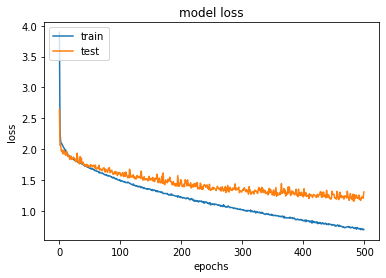

In [9]:
 plt.plot(model_convnet.history['loss'])
 plt.plot(model_convnet.history['val_loss'])
 plt.title('model loss')
 plt.xlabel('epochs')
 plt.ylabel('loss')
 plt.legend(['train','test'], loc='upper left')
 plt.show()

In [10]:
model_name = "Speech_Emotion_Recognition.h5"
save_dir = os.path.join(os.getcwd(),'saved_cnn')
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print(model_path)

/content/saved_cnn/Speech_Emotion_Recognition.h5
